# Introduction

In [1]:
%matplotlib inline

import torch
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy.fft as fft
from scipy.signal import convolve2d
from scipy import ndimage
from math import pi 
import torch
import cv2

# Q1 Scale Invariant Detection

## Laplacians of Gaussians

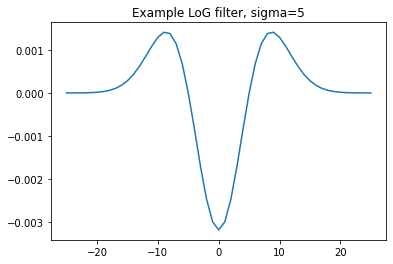

In [20]:
def log1d(sigma, num_points):
  """
  Returns num_points sampled the laplacian of a Gaussian with std=sigma
  
  Output is symmetric with unit sampling period.
  Zero is sampled only when num_points is odd.
  Examples:
    if num_points==3, sample points are [-1,0,1]
    if num_points==4, sample points are [-1.5, -0.5, 0.5, 1.5]
  Inputs:
    sigma: standard deviation
    num_points: output length.
  Outputs:
    laplacian_of_gaussian: a numpy array representing the laplacian of the 
    gaussin  of dimension (num_points)
  """
  """ INSERT YOUR CODE HERE """
  sample = np.arange(-num_points / 2 + 0.5, num_points / 2 + 0.5, 1)
  laplacian_of_gaussian = ((sample ** 2 - sigma ** 2) / (sigma ** 5 * np.sqrt(2 * np.pi))) * \
                            np.exp(-0.5 * (sample ** 2 / sigma ** 2))

  """ END YOUR CODE """
  assert(len(laplacian_of_gaussian.shape) == 1 and \
         laplacian_of_gaussian.shape[0] == num_points)
  return laplacian_of_gaussian

sigma = 5
num_points = 51
laplacian_of_gaussian = log1d(sigma, num_points)

mag = (num_points + 1)/2
step = 2 * mag / (num_points + 1)
x = np.arange(start=-mag, stop=mag, step=step)[1:]

plt.figure()
plt.plot(x, laplacian_of_gaussian)
plt.title("Example LoG filter, sigma={}".format(sigma))
pass

## Approximating a LoG by a DoG

In [18]:
def dog1d(sigma, k, num_points):
  """DOG1D - return difference of gaussians of std k*sigma and sigma
  Syntax: g = dog1d(sigma, k, num_points)

  Output is symmetric with unit sampling period.
  Zero is sampled only when num_points is odd.

  Inputs:
    sigma: standard deviation
    k: standard deviation ratio
    num_points: output length.
  Outputs:
    dog: a numpy array of difference of gaussians with dimension (num_points)
  """

  """ INSERT YOUR CODE HERE """
  
  sample = np.arange(-num_points / 2 + 0.5, num_points / 2 + 0.5, 1)
  sigma_1 = k * sigma
  gaussian_1 = (1 /( sigma_1 * np.sqrt(2 * np.pi))) * np.exp( -0.5 * (sample**2)/(sigma_1 ** 2))
    
  sigma_2 = sigma
  gaussian_2 = (1 /( sigma_2 * np.sqrt(2 * np.pi))) * np.exp( -0.5 * (sample**2)/(sigma_2 ** 2))
  
  dog = gaussian_1 - gaussian_2
  """ END YOUR CODE """

  assert(len(dog.shape) == 1 and dog.shape[0] == num_points)
  return dog

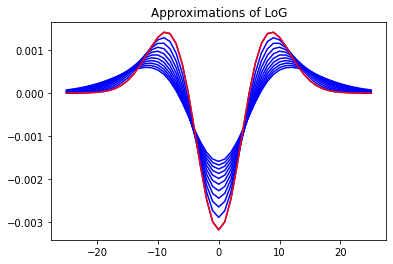

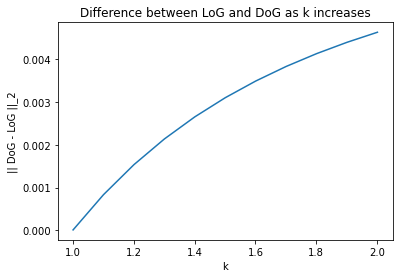

In [19]:
k_range = np.arange(1.001, 2.1, 0.1)
diffs = []
approximations = []
for k in k_range:
  """ INSERT YOUR CODE HERE """
  # Approximate the LoG with the DoG, computed with a standard deviation ratio
  # of k
  
  dog = dog1d(sigma, k, num_points)
  log_approx = dog / ((k - 1) * sigma ** 2)

  """ END YOUR CODE """

  assert(len(log_approx.shape) == 1 and log_approx.shape[0] == num_points)
  approximations.append(log_approx)
  diffs.append(np.sqrt(np.sum((laplacian_of_gaussian - log_approx)**2)))


plt.figure()
for approx in approximations:
  plt.plot(x, approx, color='b')

plt.plot(x, laplacian_of_gaussian, color='r')

plt.title('Approximations of LoG')

plt.figure()
plt.plot(k_range, diffs)
plt.xlabel('k')
plt.ylabel('|| DoG - LoG ||_2')
plt.title('Difference between LoG and DoG as k increases')
pass

## Detecting Sunflowers

### Gaussian 2D Kernel

In [ ]:
def gaussian2d(sigma, num_points):
  """ Makes a discrete centered 2d gaussian
  Output is symmetric with unit sampling period.
  (0,0) is sampled only when num_points is odd.

  sigma - standard deviation
  num_points - number of points to sample in each dimension

  Output:
    g - a num_points x num_points tensor containing samples from the gaussian
  """
  """ INSERT YOUR CODE HERE """


  """ END YOUR CODE """
  assert(g.shape == (num_points, num_points))
  return g

### Load image

In [ ]:
""" Loads and displays the sunflower image.  You must upload the image by 
clicking on the folder icon to the left, then clicking upload.  You will have to
re-upload the image every time your colab session restarts.
"""

# Inverts color channels because cv2 reads images as BGR while matplotlib
# uses RGB
original_im = cv2.imread('sunflowers.jpg')[:, :, ::-1]
#original_im = cv2.imread('balloons.jpg')[:, :, ::-1]
original_im = cv2.resize(original_im, (0,0), fx=0.5, fy=0.5)
plt.imshow(original_im)

plt.figure()
# Discard everything except the green channel (where sunflowers seem to be
# salient)
im = original_im[:, :, 1]
plt.imshow(im, cmap='Greys')
# Puts the image onto the gpu
im = torch.tensor(im).to(torch.float32).cuda()
pass

###  Detecting Blobs

In [ ]:
# Scale space parameters
n_scales = 7 #10#30

sigma = 3
k = math.sqrt(2)

# Create blurred versions of the image with different scale filters
filtered_ims = torch.zeros(n_scales+1, im.shape[0], im.shape[1])
for i in range(0, n_scales + 1):
  sigma_i = sigma * k ** i
  fSize = 2 * int(5*sigma_i)+1

  """ YOUR CODE HERE """
  # Blur the image with a 2D gaussian filter with standard deviation sigma_i
  # and a size of fSize x fSize.

  # This operation is pretty computationally expensive, so it should be run
  # on the gpu.
  # Solutions that do not perform their computation on the gpu will not be 
  # graded.

  """ END YOUR CODE """

  filtered_ims[i] = filtered

# Difference of Gaussians
dog = filtered_ims[1:, :, :] - filtered_ims[:1, :, :]

# Performs non-maximal supression across x, y, and sigma
points = [[], [], [], []]
np_dog = dog.cpu().numpy().astype(np.float32)
max_across_scales = np.max(np_dog, axis=0)
dilated_max_across_scales = cv2.dilate(max_across_scales, np.ones((3, 3), np.uint8))

for i, image in enumerate(np_dog):
  np_im = image
  np_im[dilated_max_across_scales != np_im] = 0.0
  
  xs, ys = np.where(np_im > 0.0)
  scores = np_im[xs, ys]
  points[0].extend(list(xs))
  points[1].extend(list(ys))
  points[2].extend(list(scores))
  points[3].extend([i] * len(scores))
points = torch.tensor(points)

# Discard maxima near the borders
threshold = 10
valid_indices = torch.where((points[0] > threshold) &
                            (points[1] > threshold) &
                            (points[0] < im.shape[0] - threshold) &
                            (points[1] < im.shape[1] - threshold))[0]
points = points[:, valid_indices]
points = points.reshape(points.shape[0], -1)

""" YOUR CODE HERE """
# Keep only local maxima that have a response above
# 50% of the maximum response over the whole 3D scale
# space

""" END YOUR CODE """

fig, ax = plt.subplots(1)

ax.imshow(original_im)
for i in range(points.shape[1]):
  point = points[:, i]

  # Calculate the radius of the circle you will display
  radius = sigma * k ** point[3] * math.sqrt(2)

  circle = plt.Circle((point[1], point[0]), radius, color='r', fill=False)
  ax.add_patch(circle)


# Q2 Finding Waldo with Gabor filters


## Gabor 2D Filter

In [ ]:
def gaborFilter2D(T_f, theta, sigma, length):
  # This function returns two 2D Gabor quadrature filters
  # (square matrices).
  # For this implementation of this function you can use your 
  # implementation of gaussian2d
  #
  # ARGUMENTS
  # - T_f: spatial period in pixels
  # - theta: carrier orientation in degrees (0 corresponds
  # to oscillation along x-axis only)
  # - sigma: covariance of Gaussian envelope
  # - length: output is length x length.
  #
  # OUTPUT
  # filter_cos, filter_sin: two 2d matrices containing the real part
  # and the imaginary part of the filter

  ''' INSERT YOUR CODE HERE '''

  ''' END YOUR CODE '''
  return filter_cos, filter_sin

### Check Gabor filter

In [ ]:
incr_frequency=cv2.imread('increased_frequency.png')[:,:,0]
incr_frequency=incr_frequency/255
incr_frequency=torch.from_numpy(incr_frequency-np.mean(incr_frequency[:])).float()
image_shape=incr_frequency.shape

plt.figure()
plt.imshow(incr_frequency,cmap='gray')
plt.title("Original image")
plt.show()

# Get real and imaginary part of Gabor filter for different periods
# and angles

T_f_list=[20,30,10]
theta_list=[30,60,270]
for T_f, theta in zip(T_f_list,theta_list):

  length=3*T_f
  g1,g2=gaborFilter2D(T_f,theta,T_f/np.sqrt(2),length)

  ''' INSERT YOUR CODE HERE '''
  # Convolve image incr_frequency with the gabor filter
  # and compute the real response (real), the imaginary response (imag)
  # and the magnitude of the response (magnitude)

  ''' END YOUR CODE '''

  f=plt.figure()
  f.set_size_inches(15, 7.5)
  ax=f.add_subplot(131)
  ax.imshow(real)
  ax.set_title("Real response Tf="+str(T_f)+", theta="+str(theta))

  ax=f.add_subplot(132)
  ax.imshow(imag)
  ax.set_title("Imaginary response Tf="+str(T_f)+", theta="+str(theta))

  ax=f.add_subplot(133)
  ax.imshow(magnitude)
  ax.set_title("Magnitude of response Tf="+str(T_f)+", theta="+str(theta))
  plt.show()

## Where is Waldo?

### Determine the period of the given stripe pattern

In [ ]:
def determineStripePeriod(pattern_image_path):
  # Determines the period of stripes in a grayscale (2D) Waldo image,
  # with the following method:
  # The input argument is the path of an image containing only the stripe 
  # of Waldo's shirt
  # After performing FFT it find the vertical frequency (w_y) in the range [0,pi]
  # that corresponds to the largest amplitude 
  # Using w_y it recovers the period T_y of the stripe pattern
  #
  # ARGUMENTS
  # -pattern_image_path: path to the image containing Waldo's shirt pattern
  # OUTPUT
  # - T_y: estimated spatial period of the stripes in the patch (in
  # *pixels*)


  # User chooses a patch in the image
  stripe_image=cv2.imread(pattern_image_path)[:,:,::-1]
  
  stripe_image=stripe_image/255
  gray_pattern = stripe_image[:,:,0] - 0.5*(stripe_image[:,:,1] + stripe_image[:,:,2]);
  gray_pattern[gray_pattern < np.mean(gray_pattern[:])] = np.mean(gray_pattern[:]);
  gray_pattern=gray_pattern-np.mean(gray_pattern)

  fft_mag = np.abs((fft.fft2(gray_pattern)));
  
  plt.figure()
  plt.imshow(fft_mag)
  plt.title('FFT of stripe pattern (without fftshift)')
  plt.show()

  # Pick the part of the spectrum corresponding to frequencies 
  # (w_y,w_x) in [0,pi]x[0,pi]
  fft_size=fft_mag.shape
  fft_mag=fft_mag[0:fft_size[0]//2,0:fft_size[1]//2]
  
  ''' INSERT YOUR CODE HERE '''
  # Get the frequency along the y axis with the highest amplitude

  # Using the frequency recover the period T_y of the pattern in pixels

  ''' END YOUR CODE '''

  return T_y

### Load image

In [ ]:

# Load the image
image=cv2.imread('waldo.jpg')[:,:,::-1]

# Transformation to a greyscale where red-and-white stripes
# appear black-and-white
image=image/255
im_red = image[:,:,0] - 0.5*(image[:,:,1] + image[:,:,2]);
im_red[im_red < np.mean(im_red[:])] = np.mean(im_red[:]);
im_red = im_red - np.mean(im_red[:]);

# Show the images
plt.figure(figsize=[12.8,8.6])
plt.imshow(image,interpolation='nearest')
plt.title('Original Image')
plt.show()


plt.figure(figsize=[12.8,8.6])
plt.imshow(im_red,cmap='gray')
plt.title('Special Grayscale for red-and-white patterns')
plt.show()

### Compute candidate areas containing the stripe pattern

In [ ]:
# Find out period of stripes
T_y = determineStripePeriod("stripe_pattern.jpg")
print("Stripe period is ",T_y, " pixels")
#Generate vertical Gabor filter for T_y
g1,g2 = gaborFilter2D(T_y, 90, T_y/np.sqrt(2), 3*round(T_y))

''' INSERT YOUR CODE HERE '''
# Convolve the grayscale image with the gabor filter and compute 
# the magnitude (mag) of the response


''' END YOUR CODE '''

# Create mask with all the candidate points
mask = mag>0.70*np.max(mag[:])

### Plot results

In [ ]:
# Plot the output corresponding to the neighborhood in the image where the convolution with the
# gabor kernels give the largest amplitude

# Dilate mask
se=np.array(cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(40,40)))
dil_mask= ndimage.binary_dilation(mask,structure=se,iterations=2)
dil_mask=np.expand_dims(dil_mask,axis=2)

# Plot the results
plt.figure(figsize=[12.8,8.6])
masked_image=np.multiply(dil_mask,image)
plt.imshow(masked_image)
plt.show()